# Projet 07 : Effectuer une prédiction de revenus

---
**Importation des librairies**

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as plticker
import matplotlib.colors as plc
import seaborn as sns
import scipy.stats as st
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
import modules_perso.sf_graphiques as sfg

---
## <font color=blue>Mission 4 : Modélisation du revenu des individus</font>

### 4.5.  ANOVA du logarithme du revenu basée sur le logarithme du revenu moyen et l'indice de Gini du pays

In [4]:
data = pd.read_csv("data_analyse04.csv", index_col=0)
data.head()

C:\Anaconda3\envs\Jupyter\lib\site-packages\numpy\lib\arraysetops.py:569: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  mask |= (ar1 == a)


,ln_child_income,ln_revenu_moyen,gini_from_centiles
0,6.591534,8.004643,32.141019
1,6.591534,8.004643,32.141019
2,6.591534,8.004643,32.141019
3,6.591534,8.004643,32.141019
4,6.591534,8.004643,32.141019


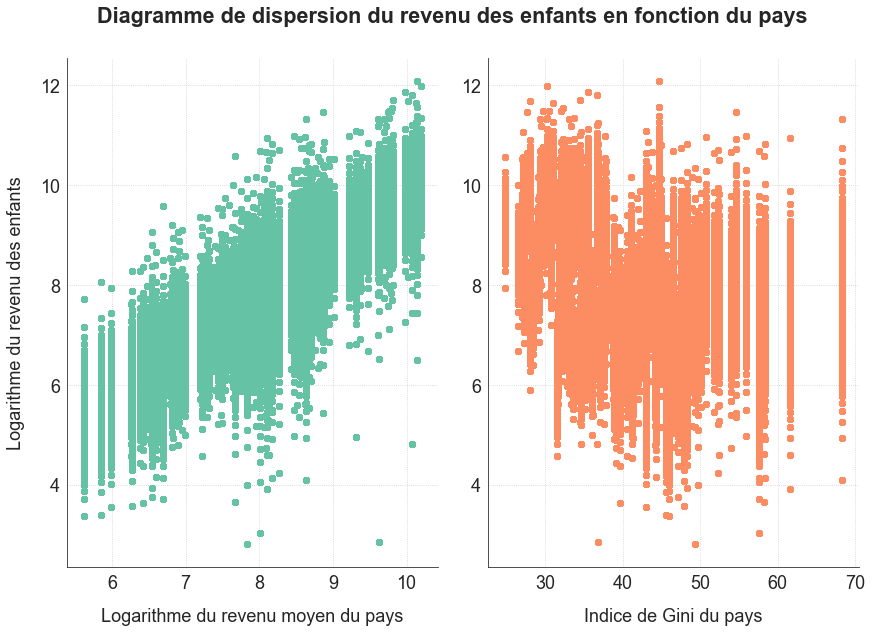

In [5]:
mygraph = sfg.MyGraph("Diagramme de dispersion du revenu des enfants en fonction du pays", nblin=1, nbcol=2, is_mono=False)
mygraph.add_plot(data.ln_revenu_moyen, data.ln_child_income, label="", marker='o', markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], linestyle='', with_grid='both', grid_style=":", multi_index=1)
mygraph.add_plot(data.gini_from_centiles, data.ln_child_income, label="", marker='o', markeredgecolor=mygraph.liste_couleurs[1], markerfacecolor=mygraph.liste_couleurs[1], linestyle='', with_grid='both', grid_style=":", multi_index=2)
mygraph.set_axe('x', label="Logarithme du revenu moyen du pays", multi_index=1)
mygraph.set_axe('x', label="Indice de Gini du pays", multi_index=2)
mygraph.set_axe('y', label="Logarithme du revenu des enfants", multi_index=1)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04_00_diagramme_dispersion.png")
plt.show()

La dispersion des revenus des enfants est moins forte lorsque l'on considère le logarithme des revenus. La relation linéaire croissante entre le logarithme du revenu des enfants et le logarithme du revenu moyen du pays se dessine nettement. Le nuage de point du logarithme du revenu des enfants en fonction de l'indice de Gini ne montre pas de relation évidente mais est bien moins dispersé qu'avant.

In [6]:
anova = smf.ols(formula="ln_child_income ~ ln_revenu_moyen + gini_from_centiles", data=data).fit()

In [7]:
anova.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:        ln_child_income   R-squared:                       0.729
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                 7.573e+06
Date:                Fri, 11 Oct 2019   Prob (F-statistic):               0.00
Time:                        10:37:52   Log-Likelihood:            -6.1619e+06
No. Observations:             5642420   AIC:                         1.232e+07
Df Residuals:                 5642417   BIC:                         1.232e+07
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
======================================================================================
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
Intercept              0.4956      0.003    166.745      0.000       0.490       0.501
ln_revenu_moyen        0.9864      0.000   3579.159      0.000       0.986       0.987
gini_from_centiles    -0.0165   3.54e-05   -467.180      0.000      -0.017      -0.016
==============================================================================
Omnibus:                   366514.715   Durbin-Watson:                   0.001
Prob(Omnibus):                  0.000   Jarque-Bera (JB):          1733049.071
Skew:                          -0.087   Prob(JB):                         0.00
Kurtosis:                       5.709   Cond. No.                         406.
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [8]:
table_anova = sm.stats.anova_lm(anova, typ=2)
table_anova.loc["total","sum_sq"] = table_anova.loc[:,"sum_sq"].sum()
table_anova.loc["total","df"] = table_anova.loc[:,"df"].sum()
table_anova["eta_squared"] = table_anova[:-2]["sum_sq"] / table_anova.loc["total","sum_sq"]
cmr = table_anova["sum_sq"][-1] / table_anova["df"][-1]
table_anova["omega_squared"] = (table_anova[:-2]["sum_sq"] - (table_anova[:-2]["df"] * cmr)) / (table_anova.loc["total","sum_sq"] + cmr)
table_anova

,sum_sq,df,F,PR(>F),eta_squared,omega_squared
ln_revenu_moyen,6.662550e+06,1.0,1.281038e+07,0.0,0.686109,0.686109
gini_from_centiles,1.135132e+05,1.0,2.182568e+05,0.0,0.011690,0.011689
Residual,2.934565e+06,5642417.0,NaN,NaN,NaN,NaN
total,9.710628e+06,5642419.0,NaN,NaN,NaN,NaN


La part de dispersion expliquée par le modèle (R²) est de 72,9%, comme pour le modèle 2. Nous obtenons également un AIC et un BIC équivalents au modèle 2.  
L'ANOVA conclut à la significativité des deux variables. La prise en considération du logarithme du revenu rend donc l'indice de Gini significatif. Cette observation est à modérer par le fait que le logarithme du revenu moyen est le très net contributeur principal du modèle (omega squared de 0,686 contre 0.012 pour l'indice de Gini).

Vérifions le respect des hypothèses sur la normalité des résidus, la linéarité de la relation et l'homoscédasticité.

### Vérification des hypothèses

**Hypothèse 1 : Normalité des résidus**

In [9]:
alpha_normalite = 0.05
ad_stat, ad_pvalue = sm.stats.normal_ad(anova.resid)
norm_stat, norm_pvalue = st.kstest(anova.resid, cdf='norm', args=(anova.resid.mean(), anova.resid.var(ddof=1)))
jb_stat, jb_pvalue, skw, kurt = sm.stats.stattools.jarque_bera(anova.resid)
df_normalite = pd.DataFrame({'H0':np.repeat("Distribution normale",3), 'Statistique':["{:.2f}".format(ad_stat),"{:.2f}".format(norm_stat),"{:.2f}".format(jb_stat)], \
                             'p-value':["{:.3f}".format(ad_pvalue),"{:.3f}".format(norm_pvalue),"{:.3f}".format(jb_pvalue)]}, index=["Anderson-Darling","Kolmogorov-Smirnov","Jarque-Bera"])
inter_col = "Résultat (seuil={:.1%})".format(alpha_normalite)
df_normalite[inter_col] = ["Normalité acceptée" if float(pval)>=alpha_normalite else "Normalité rejetée" for pval in df_normalite["p-value"]]
df_normalite

C:\Anaconda3\envs\Jupyter\lib\site-packages\statsmodels\stats\_adnorm.py:66: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  S = np.sum((2*i[sl1]-1.0)/N*(np.log(z)+np.log(1-z[sl2])), axis=axis)


,H0,Statistique,p-value,Résultat (seuil=5.0%)
Anderson-Darling,Distribution normale,19921.05,0.000,Normalité rejetée
Kolmogorov-Smirnov,Distribution normale,0.05,0.000,Normalité rejetée
Jarque-Bera,Distribution normale,1733049.07,0.000,Normalité rejetée


Aucun des trois test n'accepte la normalité. Nous avons un grand nombre d'observations. Une symétrie de la distribution des résidus sera suffisante. Je vérifie graphiquement cette symétrie, et je trace également la droite de Henry.

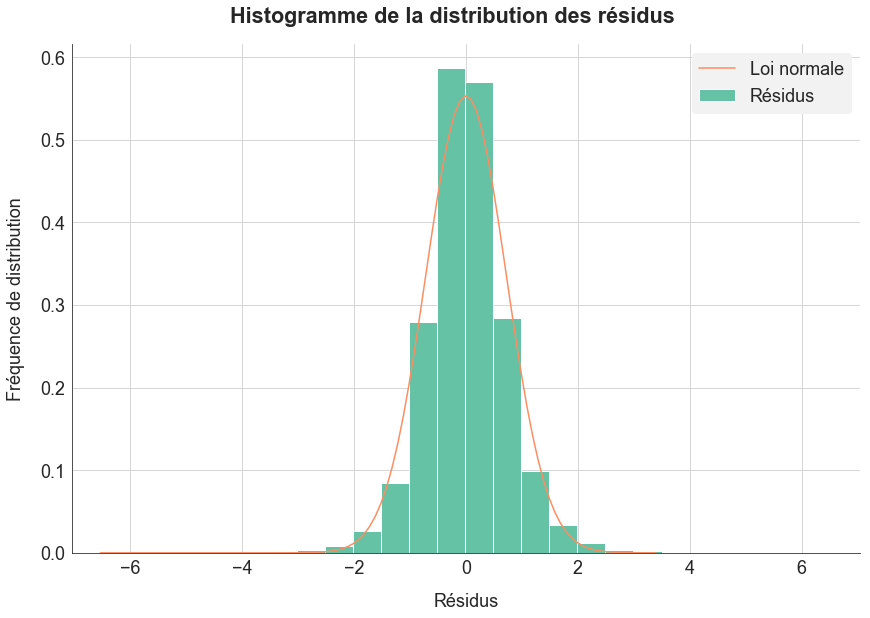

In [10]:
x_theo = np.arange(anova.resid.min(), anova.resid.max(), 0.01*(anova.resid.max()-anova.resid.min()))
mygraph = sfg.MyGraph("Histogramme de la distribution des résidus", is_mono=False)
mygraph.add_histogramme(anova.resid, bins=20, labels="Résidus")
mygraph.add_plot(x_theo, st.norm.pdf(x_theo, scale=anova.resid.std(ddof=1)), label="Loi normale", legend=True)
xmin, xmax = mygraph.ax[0].get_xlim()
absmax = max(-xmin, xmax)
mygraph.set_axe('y', label="Fréquence de distribution")
mygraph.set_axe('x', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04_01_distribution_residus.png")
plt.show()

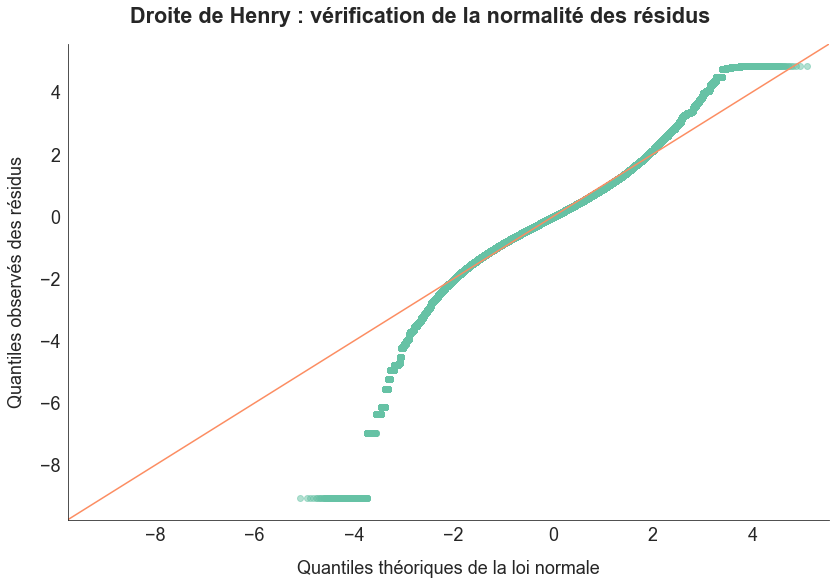

In [11]:
mygraph = sfg.MyGraph("Droite de Henry : vérification de la normalité des résidus", is_mono=False)
sm.qqplot(anova.resid, fit=True, markeredgecolor=mygraph.liste_couleurs[0], markerfacecolor=mygraph.liste_couleurs[0], alpha=0.5, ax=mygraph.ax[0])
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="", color=mygraph.liste_couleurs[1])
mygraph.set_axe('x', label="Quantiles théoriques de la loi normale")
mygraph.set_axe('y', label="Quantiles observés des résidus")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04_02_droite_henry.png")
plt.show()

On remarque que les résidus ne sont pas normaux. Par contre, ils présentent une symétrie presque parfaite. C'est la meilleure symétrie des résidus obtenue jusqu'à maintenant. Le graphique de la distribution des résidus est très satisfaisant vu le grand nombre de données de notre échantillon.  
La droite de Henry montre la difficulté de modélisation des valeurs extrêmes. Par contre, les valeurs centrales sont fidèles à la distribution normale théorique. Il peut être intéressant de tester l'ajout de l'interaction entre les 2 variables pour voir si cet ajout permet d'améliorer encore la normalité des résidus.

**Hypothèse 2 : Linéarité et additivité de la relation  
Hypothèse 3 : Homoscédasticité des résidus**

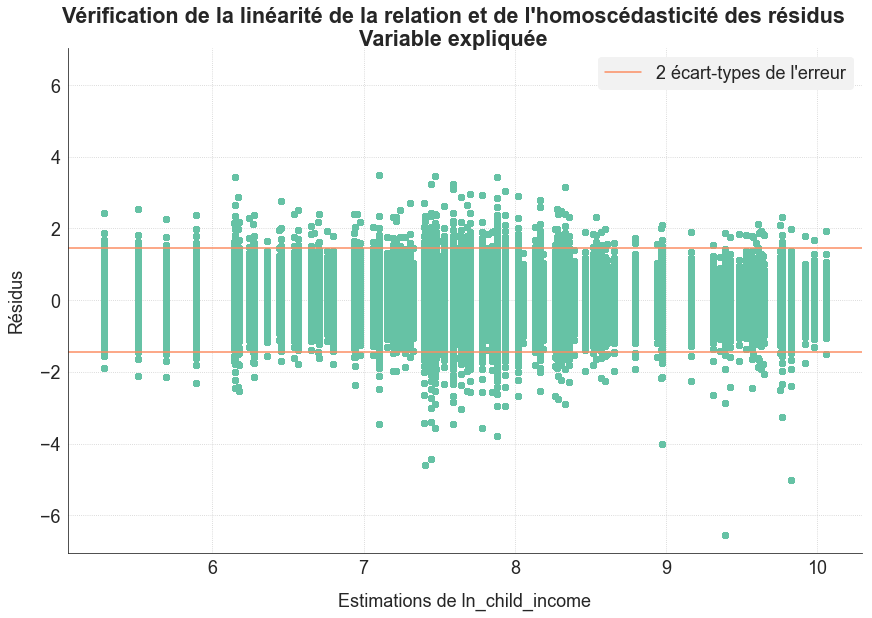

In [12]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation et de l'homoscédasticité des résidus\nVariable expliquée", is_mono=False)
mygraph.add_plot(anova.fittedvalues, anova.resid, label="", marker='o', linestyle='', with_grid='both', grid_style=":")
yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1])
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Estimations de ln_child_income")
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04_03_linearite_homoscedasticite_endo.png")
plt.show()

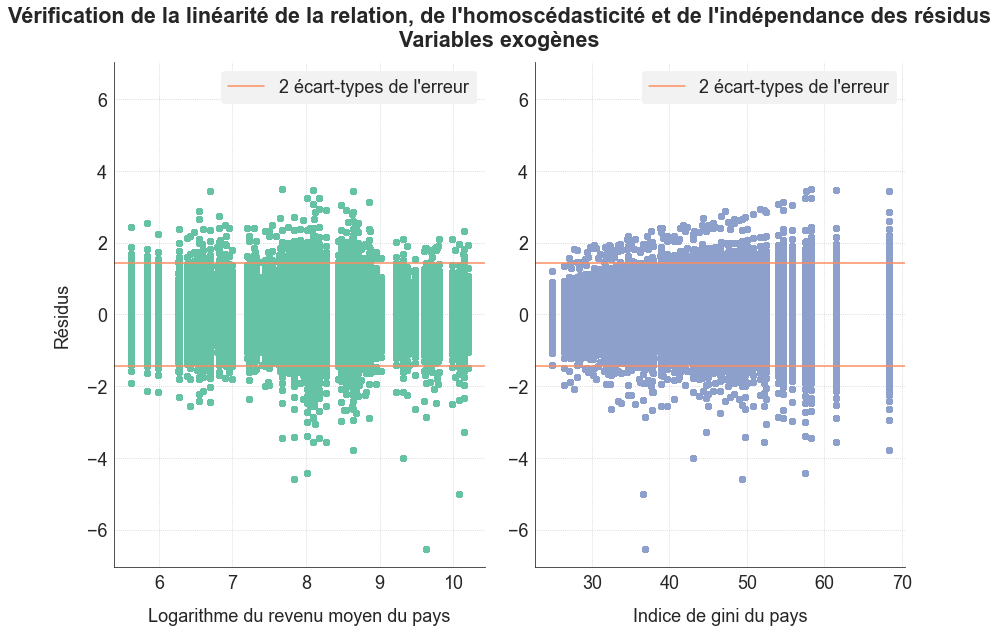

In [13]:
mygraph = sfg.MyGraph("Vérification de la linéarité de la relation, de l'homoscédasticité et de l'indépendance des résidus\nVariables exogènes", nblin=1, nbcol=2, is_mono=False)
mygraph.add_plot(data.ln_revenu_moyen, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[0], linestyle='', with_grid='both', grid_style=":", multi_index=1)
mygraph.add_plot(data.gini_from_centiles, anova.resid, label="", marker='o', color=mygraph.liste_couleurs[2], linestyle='', with_grid='both', grid_style=":", multi_index=2)
#yseuil = 2 * np.sqrt(table_anova.loc["Residual","sum_sq"] / table_anova.loc["Residual","df"])
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=1)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=1)
mygraph.add_line(-yseuil, vertical=False, color=mygraph.liste_couleurs[1], multi_index=2)
mygraph.add_line(yseuil, vertical=False, label="2 écart-types de l'erreur", color=mygraph.liste_couleurs[1], legend=True, multi_index=2)
ymin, ymax = mygraph.ax[0].get_ylim()
absmax = max(-ymin, ymax, 1.1*yseuil)
mygraph.set_axe('x', label="Logarithme du revenu moyen du pays", multi_index=1)
mygraph.set_axe('x', label="Indice de gini du pays", multi_index=2)
mygraph.set_axe('y', label="Résidus", tick_min=-absmax, tick_max=absmax, multi_index=1)
mygraph.set_axe('y', tick_min=-absmax, tick_max=absmax, multi_index=2)
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04_04_linearite_homoscedasticite_exo.png")
plt.show()

In [14]:
alpha_homo = 0.05
lm_stat, lm_pvalue, f_stat, f_pvalue = sm.stats.diagnostic.het_breuschpagan(anova.resid, anova.model.exog)
if f_pvalue >= alpha_homo:
    test_result = ["Homoscédasticité acceptée"]
else:
    test_result = ["Homoscédasticité rejetée"]
pd.DataFrame({'H0':["Variance des résidus constante"], 'Statistique':["{:.2f}".format(f_stat)], \
             'p-value':["{:.3f}".format(f_pvalue)], 'Résultat (seuil={:.1%})'.format(alpha_homo):test_result}, index=["Breusch Pagan"])

,H0,Statistique,p-value,Résultat (seuil=5.0%)
Breusch Pagan,Variance des résidus constante,181753.29,0.000,Homoscédasticité rejetée


L'homoscédasticité est rejetée par le test. Par contre, les graphiques montrent que les résidus sont désormais assez bien répartis dans les valeurs positives et négatives. Les graphiques sont satisfaisants et permettent de valider les hypothèses d'homoscédasticité des résidus et de linéarité de la relation générale.  
Le graphique des résidus en fonction des valeurs de l'indice de Gini montre que la dispersion des résidus semble plus élevée lorsque l'indice de Gini augmente. Cela pose la question de l'indépendance des résidus par rapport à l'indice de Gini. Mais cette observation est explicable par la définition de l'indice de Gini. L'indice de Gini définit la concentration des revenus au sein de la population du pays. Plus il est élevé, plus les revenus sont concentrés. Cette concentration se traduit en général par des riches plus riches et des pauvres plus pauvres par rapport à la médiane du pays. Et donc par une dispersion des revenus plus importante.

**Conclusion sur les hypothèses**

Les graphiques permettent d'accepter les 3 hypothèses et de pousser plus avant l'analyse du modèle.

Ils éclairent aussi sur l'intérêt de tester deux variantes de ce modèle :  
- l'une sans l'indice de Gini : la variable est significative mais elle contribue peu au modèle, et son indépendance avec les résidus n'est pas certaine. Il est intéressant d'analyser le modèle sans cette variable. Cette étude est menée dans le notebook [data_analyst_projet07_M44_modelisation04-variantesansgini](data_analyst_projet07_M44_modelisation04-variantesansgini.ipynb) et conclut qu'il est préférable de conserver l'indice de Gini ;  
- l'une en gardant l'indice de Gini et en ajoutant l'interaction entre les 2 variables. Cette étude est menée dans le notebook [data_analyst_projet07_M44_modelisation04-varianteavecinteraction](data_analyst_projet07_M44_modelisation04-varianteavecinteraction.ipynb)

**Vérification supplémentaire : absence de colinéarité entre les exogènes**

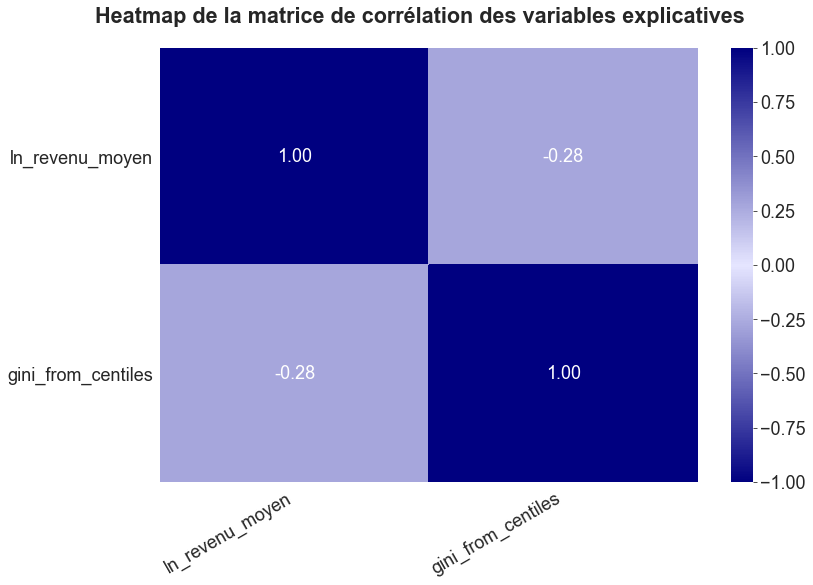

In [15]:
matrice_correl = np.corrcoef(data[["ln_revenu_moyen","gini_from_centiles"]], rowvar=False)
mygraph = sfg.MyGraph("Heatmap de la matrice de corrélation des variables explicatives", is_mono=True)
sns.heatmap(matrice_correl, vmin=-1, vmax=1, fmt='.2f', cmap=plc.LinearSegmentedColormap.from_list("", [mygraph.liste_couleurs[-1],mygraph.liste_couleurs[0],mygraph.liste_couleurs[-1]]), \
            cbar_kws={'ticks':[-1,-0.75,-0.5,-0.25,0,0.25,0.5,0.75,1]}, annot=True, ax=mygraph.ax[0])
mygraph.set_axe('y', tick_labels=["ln_revenu_moyen","gini_from_centiles"], rotation=0)
mygraph.set_axe('x', tick_labels=["ln_revenu_moyen","gini_from_centiles"], rotation=30, ha='right')
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04_05_matrice_correl.png")
plt.show()

In [16]:
variables = anova.model.exog
vif_analysis = pd.DataFrame([variance_inflation_factor(variables, i) for i in np.arange(1,variables.shape[1])], \
                          index=[var for var in anova.model.exog_names if var!="Intercept"], columns=["VIF"])
print("ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)")
vif_analysis

ANALYSE DE LA MULTI-COLINÉARITÉ (l'indice VIF doit être inférieur à 4)


,VIF
ln_revenu_moyen,1.084693
gini_from_centiles,1.084693


Les deux variables sont peu liées entre elles. Il n'y a pas de problème de colinéarité.

**Vérification de la pertinence des estimations par rapport aux valeurs réelles**

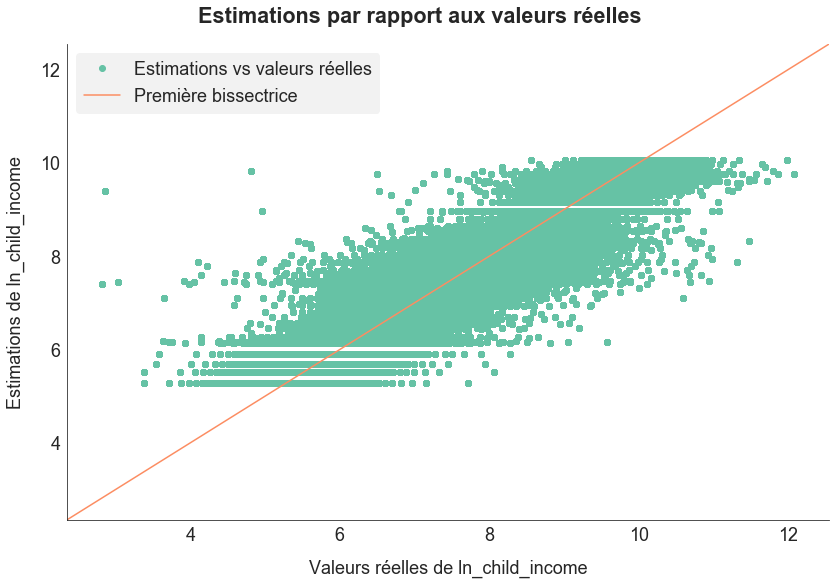

In [17]:
mygraph = sfg.MyGraph("Estimations par rapport aux valeurs réelles", is_mono=False)
mygraph.add_plot(data.ln_child_income, anova.fittedvalues, label="Estimations vs valeurs réelles", marker='o', linestyle="")
ymin, ymax = mygraph.ax[0].get_ylim()
xmin, xmax = mygraph.ax[0].get_xlim()
data_min = min(xmin, ymin)
data_max = max(xmax, ymax)
mygraph.add_plot([data_min, data_max], [data_min, data_max], label="Première bissectrice", legend=True)
mygraph.set_axe('y', label="Estimations de ln_child_income")
mygraph.set_axe('x', label="Valeurs réelles de ln_child_income")
mygraph.ax[0].autoscale(enable=True, axis='both', tight=True)
mygraph.fig.tight_layout()
fig, ax = mygraph.fig, mygraph.ax
plt.savefig("anova04_06_accuracy_graph.png")
plt.show()

Comme les analyses précédentes le supposent, les valeurs élevées de child income sont mieux évaluées par ce modèle (par rapport au modèle 3). Par contre, les estimations restent très dispersées par rapport à la première bissectrice.

**Analyse des outliers**

In [18]:
n, p = anova.model.exog.shape
p = p - 1  # j'enlève la constante du nombre de paramètres pour ajuster les seuils
seuils = pd.Series(index=["levier", "resid_student", "dffits", "cook","dfbetas"])
seuils.levier = 2 * (p + 1) / n
seuils.dffits = 2 * np.sqrt((p + 1) / n)
seuils.cook = 4 / (n - p - 1)
seuils.resid_student = st.t.ppf(1-(0.05/2), n-p-2)  # seuil de 5% pour les résidus studentisés
reg_influence = anova.get_influence()
analyses = pd.DataFrame({"observation_name":data.index})
analyses["levier"] = reg_influence.hat_matrix_diag
#analyses["external_resid_student"] = reg_influence.resid_studentized_external
#analyses["outlier"] = ((analyses.levier > seuils.levier) | (abs(analyses.external_resid_student) > seuils.resid_student))
analyses["outlier"] = analyses.levier > seuils.levier
#analyses["dffits"] = reg_influence.dffits[0]
analyses["cook_distance"] = reg_influence.cooks_distance[0]
analyses["influence"] = analyses.cook_distance > seuils.cook
#analyses["influence"] = (abs(analyses.dffits) > seuils.dffits) | (analyses.cook_distance > seuils.cook)

In [19]:
seuils[["levier","cook"]].to_frame().style.format("{:.8f}")

,0
levier,0.00000106
cook,0.00000071


In [20]:
only_both = False
if only_both == False:
    print("Résumé des observations atypiques OU influentes")
    variables_speciales = analyses[(analyses.outlier | analyses.influence) & (analyses.outlier != analyses.influence)]
    print(variables_speciales)
    print("")
print("Résumé des observations atypiques ET influentes")
variables_investigation = analyses[analyses.outlier & analyses.influence]
variables_investigation

Résumé des observations atypiques OU influentes
         observation_name        levier  outlier  cook_distance  influence
49349               49349  3.234395e-07    False   7.672103e-07       True
49350               49350  3.234395e-07    False   7.672103e-07       True
49351               49351  3.234395e-07    False   7.672103e-07       True
49352               49352  3.234395e-07    False   7.672103e-07       True
49353               49353  3.234395e-07    False   7.672103e-07       True
49354               49354  3.234395e-07    False   7.672103e-07       True
49355               49355  3.234395e-07    False   7.672103e-07       True
49356               49356  3.234395e-07    False   7.672103e-07       True
49357               49357  3.234395e-07    False   7.672103e-07       True
49358               49358  3.234395e-07    False   7.672103e-07       True
49359               49359  3.234395e-07    False   7.672103e-07       True
49360               49360  3.234395e-07    False   7

,observation_name,levier,outlier,cook_distance,influence
1996980,1996980,0.000001,True,0.000011,True
1996981,1996981,0.000001,True,0.000011,True
1996982,1996982,0.000001,True,0.000011,True
1996983,1996983,0.000001,True,0.000011,True
1996984,1996984,0.000001,True,0.000011,True
1996985,1996985,0.000001,True,0.000011,True
1996986,1996986,0.000001,True,0.000011,True
1996987,1996987,0.000001,True,0.000011,True
1996988,1996988,0.000001,True,0.000011,True
1996989,1996989,0.000001,True,0.000011,True


Le nombre d'obervations soit atypiques soit influentes (mais pas à la fois atypiques et influentes) diminue par rapport au modèle 3 (316 802 observations, soit 5,61% de l'échantillon). Désormais, toutes ces observations sont influentes.  
Le nombre d'obervations à la fois atypiques et influentes diminue également par rapport au modèle 3 (52 311 observations, soit 0,93%).  
Si ce modèle est retenu au final, il faudra analyser ces valeurs à la fois atypiques et influentes.

**Conclusion sur ce modèle**

L'opération de feature engineering consistant à remplacer les revenus par le logarithme des revenus améliore le modèle. Les hypothèses sont mieux respectées et les résultats de la modélisation meilleure.  
Les résultats sont aussi satisfaisants que ceux obtenus avec le modèle basé sur le country_code. Les résidus présentent une meilleure symétrie et donc une meilleure normalité. Ce modèle présente surtout deux avantages. D'une part, il est bien plus simple avec seulement deux coefficients (plus la constante) estimés. D'autre part, si la situation d'un pays évolue, ce modèle devrait mieux prendre en compte cette évolution car il base ses estimations sur les caractéristiques du pays plutôt que sur son nom.  
Une limitation de ce modèle est de ne prévoir les revenus des enfants qu'en fonction des caractéristiques du pays. Nous pouvons légitimement penser que les revenus des parents influent sur les revenus des enfants. Nous pouvons introduire cette composante à notre analyse à travers la classe (le centile) à laquelle les revenus des parents appartiennent.